# Tarea 3 Machine Learning - Métodos no Lineales

Juan Pablo Muñoz - 201373522-3

Margarita Bugueño Pérez - 201373510-K

## 2. Bike Sharing: Predicción de Demanda Horaria

En esta parte, se simula la participación en el desafío *Bike Sharing Demand* de *Kaggle*. El objetivo, es obtener un puntaje igual o menor a $0.37748$. La función de puntaje a utilizar es la siguiente:

\begin{equation}
E_{bikes}(y,\hat{y}) = \frac{1}{n} \sum_i (\ln(y_i + 1) - \ln(\hat{y}_i + 1))^2
\end{equation}

Donde $y, \hat{y} \in \mathbb{R}^n$ son los vectores de observaciones y predicciones, respectivamente. Notar que esta métrica de puntaje se basa en una medida de *distancia* entre lo predicho y lo esperado, por lo que, entre menor sea el valor del puntaje, mejor éste será, ya que $y$ e $\hat{y}$ están más cercanos entre sí.

La descripción del dataset a utilizar es la siguiente.

| Atributo   | Descripción                                                                            |
|------------|----------------------------------------------------------------------------------------|
| datetime   | Hora del día + *timestamp*                                                             |
| season     | 1 = primavera                                                                          |
|            | 2 = verano                                                                             |
|            | 3 = otoño                                                                              |
|            | 4 = invierno                                                                           |
| holiday    | Si el día es considerado feriado                                                       |
| workingday | Si el día no es ni fin de semana ni feriado                                            |
| weather    | 1: Despejado, Nubosidad leve, Parcialmente nublado                                     |
|            | 2: Niebla+Nublado, Niebla+Nubosidad Parcial, Niebla+Nubosidad leve, Niebla             |
|            | 3: Nieve ligera, Lluvia ligera+Relámpagos+Nubosidad leve, Lluvia ligera+Nubosidad leve |
|            | 4: Lluvia fuerte+Granizo+Relámpagos+Niebla, Nieve+Niebla                               |
| temp       | Temperatura en ºC                                                                      |
| atemp      | Sensación térmica en ºC                                                                |
| humidity   | Humedad relativa                                                                       |
| windspeed  | Velocidad del viento                                                                   |
| casual     | Número de rentas hechas por usuarios no registrados en el día                          |
| registered | Número de rentas hechas por usuarios registrados en el día                             |
| count      | Total de rentas realizadas en el día                                                   |

#### (a) Cargar los datos de entrenamiento, validación y pruebas en *dataframes* y extracción de atributo *hour* desde el timestamp del atributo *datetime*.

In [1]:
import pandas as pd
import numpy as np

dftrain = pd.read_csv('bike_sharing_train.csv')
dfval = pd.read_csv('bike_sharing_val.csv')
dftest = pd.read_csv('bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
print ('\nSummary - dataframe completo:\n')
df.describe()


Summary - dataframe completo:



,Unnamed: 0,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,5442.500000,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,3142.661849,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2721.250000,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,5442.500000,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,8163.750000,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,10885.000000,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [2]:
df.columns

Index(['Unnamed: 0', 'datetime', 'season', 'holiday', 'workingday', 'weather',
       'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered',
       'count'],
      dtype='object')

In [3]:
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])

In [4]:
df.head()

,Unnamed: 0,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
0,3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3
1,4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4
2,5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,5
3,6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,6
4,7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,7


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 2146
Data columns (total 14 columns):
Unnamed: 0    10886 non-null int64
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
hour          10886 non-null int64
dtypes: float64(3), int64(10), object(1)
memory usage: 1.2+ MB


Antes de analizar el dataframe, se nota que existe una columna sin identificar, llamada `Unnamed: 0`. Esta corresponde al número de registro, y no cumple con entregar información relevante sobre el problema abordado, por lo que será eliminada. También, la columna `datetime` no aparece en la descripción del dataframe, ya que al ser de tipo `string`, no se le puede calcular estadísticos.

In [6]:
df.describe()

,Unnamed: 0,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,5442.500000,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
std,3142.661849,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2721.250000,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,5442.500000,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,8163.750000,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,10885.000000,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000


El parámetro `season` es de tipo categórico. Es decir que, la relación entre los posibles valores (1, 2, 3, 4) no es de orden entre ellos, sino de pertenencia a distintas *clases*. Otro parámetro con esta característica es `weather`. Se puede visualizar la distribución de estos datos (de entrenamiento, validación y prueba combinados) a través de histogramas.

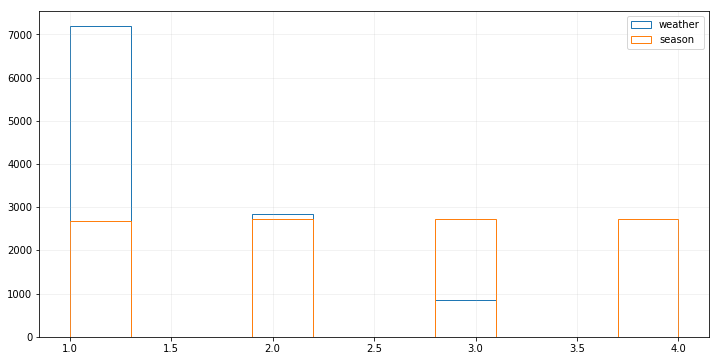

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.grid(alpha=0.2)
plt.hist(df['weather'], histtype='step', label='weather')
plt.hist(df['season'], histtype='step', label='season')
plt.legend(loc='upper right')
plt.show()

Observar que, la cantidad de registros por estación del año (naranjo) es prácticamente constante, ubicándose  al rededor de los 2600 para primavera (1), verano (2), otoño (3) e invierno (4). En cambio, la cantidad de registros difiere bastante dependiendo del tiempo actual: hay más de 7000 registros de rentas en días soleados o levemente despejados (1), al rededor de 2900 en días nublados o con neblina (2), unos 900 en días con precipitaciones de agua o nieve (3), y ninguna en los días de tormenta eléctrica o con granizos y niebla (4).

Notar que los registros no son instancias de arriendos, sino que reportan la cantidad de arriendos en la ventana de tiempo entre el *datetime* actual y el del anterior registro. Por lo tanto, se puede concluir que cuando `weather=4`, el servicio de arriendo no estuvo disponible (quizás por razones de seguridad), pues no se hicieron registros, y no porque no haya habido arriendos.

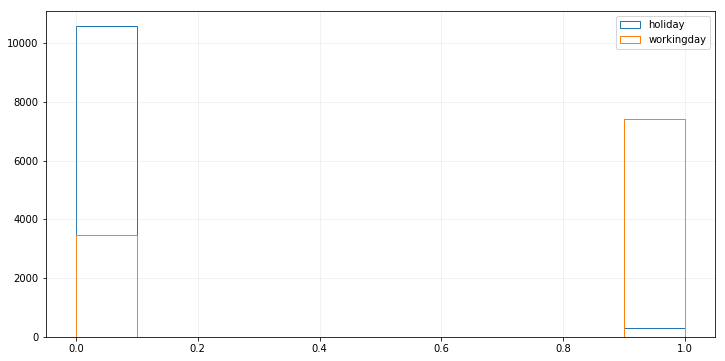

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.grid(alpha=0.2)
plt.hist(df['holiday'], histtype='step', label='holiday')
plt.hist(df['workingday'], histtype='step', label='workingday')
plt.legend(loc='upper right')
plt.show()

Otro tipo de atributo son los binarios, y los atributos `holiday` y `workingday` corresponden a esta categoría. Del histograma anterior, se nota que `holiday` (azul) es 0 para casi todos los registros, lo que tiene sentido, pues estadísticamente, los días feriados son pocos durante el año. En el caso de `workingday`, se nota que hay aproximadamente 3600 registros en los que este parámetro es 0, y 1 en el resto (unos 7500 registros). Por lo tanto, la mayoría de los registros se hicieron en días hábiles de la semana y no feriados.

Luego, los atributos `temp`, `atemp`, `humidity`, y `windspeed` son atributos de naturaleza continua, y son los que sólo requieren del preprocesado de escalado y centrado para poder ser procesados correctamente por los modelos estudiados hasta ahora. `temp` y `atemp` se mueven aproximadamente entre los valores 0 y 45. `humidity` es un porcentaje, por lo que varía entre 0 y 100. `windspeed` varía entre 0 y 57 aproximadamente.

Siguen los atributos `casual`, `registered` y `count`, que son discretos y contables. En este caso, dada su gran variabilidad entre registros (entre 0 y 980, aproximadamente), es conveniente considerarlos como continuos.

El último atributo agregado es `hour`, y su valor va desde 0 a 24. Podemos observar las horas en que más arriendos se producen.

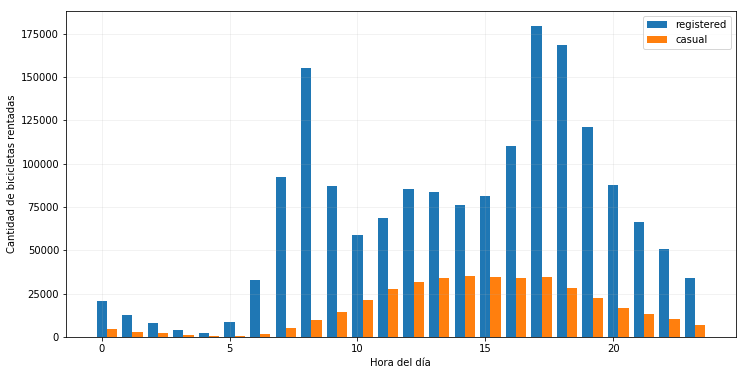

In [9]:
casual = [0]*24
registered = [0]*24

for registro in df.as_matrix():
    casual[registro[-1]] += registro[-4]
    registered[registro[-1]] += registro[-3]

f, ax = plt.subplots(figsize=(12,6))
ax.grid(alpha=0.2)
ax.bar(np.arange(24),registered, 0.4, label='registered')
ax.bar(np.arange(24)+0.4,casual, 0.4, label='casual')
ax.legend(loc='upper right')
ax.set_xlabel('Hora del día')
ax.set_ylabel('Cantidad de bicicletas rentadas')
plt.show()

Mientras la cantidad de arriendos de usuarios registrados es mucho mayor que la de casuales, estos últimos no son una cantidad despreciable. Es interesante observar que, mientras los arriendos de usuarios registrados alcanza *peaks* en horas de la mañana y en la tarde, la cantidad de arriendos de usuarios casuales varía de manera más suave, teniendo sus máximos valores al rededor de las 15:00 horas.

Finalmente, se observa la matriz de covarianza de los atributos para averiguar la existencia de correlaciones entre ellos.

La mínima cantidad de bicicletas solicitadas por hora fue:  1
La máxima cantidad de bicicletas solicitadas por hora fue:  977


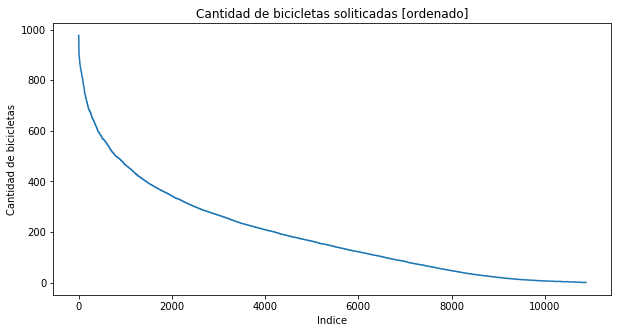

In [10]:
aux= np.sort(df['count'].values)[::-1]
print ("La mínima cantidad de bicicletas solicitadas por hora fue: ", np.min(aux))
print ("La máxima cantidad de bicicletas solicitadas por hora fue: ", np.max(aux))

plt.figure(figsize=(10,5))
plt.title("Cantidad de bicicletas soliticadas [ordenado]")
#plt.plot(aux[2000:])
plt.plot(aux)
plt.ylabel("Cantidad de bicicletas")
plt.xlabel("Indice")
plt.axis('tight')
plt.show()

In [11]:
import matplotlib.pyplot as plt

pri1 = df[ (df['season'] == 1) & (df['hour'] <= 11)]
pri2 = df[ (df['season'] == 1) & (df['hour'] > 11) & (df['hour'] <= 18)]
pri3 = df[ (df['season'] == 1) & (df['hour'] > 18) & (df['hour'] <= 24)]

sumaPri = [sum(pri1['count']),sum(pri2['count']),sum(pri3['count'])]

ver1 = df[ (df['season'] == 2) & (df['hour'] <= 11)]
ver2 = df[ (df['season'] == 2) & (df['hour'] > 11) & (df['hour'] <= 18)]
ver3 = df[ (df['season'] == 2) & (df['hour'] > 18) & (df['hour'] <= 24)]

sumaVer = [sum(ver1['count']),sum(ver2['count']),sum(ver3['count'])]

oto1 = df[ (df['season'] == 3) & (df['hour'] <= 11)]
oto2 = df[ (df['season'] == 3) & (df['hour'] > 11) & (df['hour'] <= 18)]
oto3 = df[ (df['season'] == 3) & (df['hour'] > 18) & (df['hour'] <= 24)]

sumaOto = [sum(oto1['count']),sum(oto2['count']),sum(oto3['count'])]

inv1 = df[ (df['season'] == 4) & (df['hour'] <= 11)]
inv2 = df[ (df['season'] == 4) & (df['hour'] > 11) & (df['hour'] <= 18)]
inv3 = df[ (df['season'] == 4) & (df['hour'] > 18) & (df['hour'] <= 24)]

sumaInv = [sum(inv1['count']),sum(inv2['count']),sum(inv3['count'])]

print (sumaPri, sumaVer, sumaOto, sumaInv)

[99313, 154560, 58625] [174830, 288693, 124759] [192825, 304212, 143625] [173769, 268519, 101746]


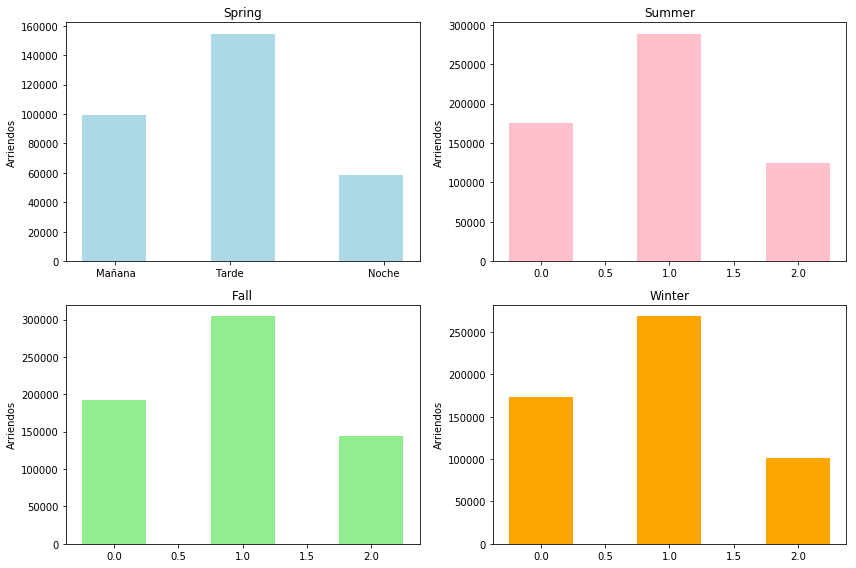

In [12]:
f, axarr = plt.subplots(2, 2, figsize=(12,8) )
axarr[0, 0].bar(np.arange(0,3,1), sumaPri, width  = 0.5, align = "center", color = 'lightblue')
axarr[0, 0].set_title('Spring')
axarr[0, 0].set_xticks([0.01,0.9, 2.1])
axarr[0, 0].set_xticklabels(('Mañana','Tarde','Noche'))
axarr[0, 0].set_ylabel('Arriendos')
axarr[0, 0].axis('tight')

axarr[0, 1].bar(np.arange(0,3,1), sumaVer, width  = 0.5, align = "center", color = 'pink')
axarr[0, 1].set_title('Summer')
axarr[0, 0].set_xticks([0.01,0.9, 2.1])
axarr[0, 0].set_xticklabels(('Mañana','Tarde','Noche'))
axarr[0, 1].set_ylabel('Arriendos')
axarr[0, 1].axis('tight')

axarr[1, 0].bar(np.arange(0,3,1), sumaOto, width  = 0.5, align = "center", color = 'lightgreen')
axarr[1, 0].set_title('Fall')
axarr[0, 0].set_xticks([0.01,0.9, 2.1])
axarr[0, 0].set_xticklabels(('Mañana','Tarde','Noche'))
axarr[1, 0].set_ylabel('Arriendos')
axarr[1, 0].axis('tight')

axarr[1, 1].bar(np.arange(0,3,1), sumaInv, width  = 0.5, align = "center", color = 'orange')
axarr[1, 1].set_title('Winter')
axarr[0, 0].set_xticks([0.01,0.9, 2.1])
axarr[0, 0].set_xticklabels(('Mañana','Tarde','Noche'))
axarr[1, 1].set_ylabel('Arriendos')
axarr[1, 1].axis('tight')

f.tight_layout() 
plt.show()

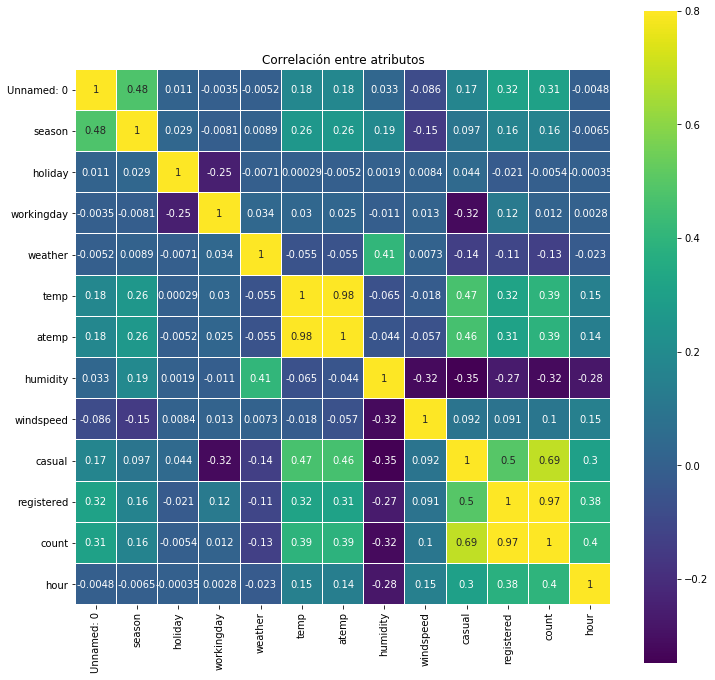

In [13]:
import seaborn as sns

plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
sns.set(font_scale=1)
plt.title('Correlación entre atributos');
plt.show()
sns.reset_orig()

Como es de esperar, la temperatura y la sensación térmica, denotados por `temp` y `atemp` respectivamente, están muy correlacionadas entre sí, con un factor de 0.98. Luego, la correlación entre `registered` y `count` también es muy fuerte, con 0.97. Le sigue `casual` y `count` con 0.69. `registered` y `casual` también se correlacionan, con un factor de 0.5. Una correlación interesante es entre `casual` y ambas `temp` y `atemp`, lo que sugiere que cuando la temperatura era "agradable", entonces la cantidad de usuarios casuales aumentaba.

También existen correlaciones negativas, como por ejemplo entre `casual` y `workingday`. Esto siguere que en los días hábiles, la cantidad de arriendos de usuarios casuales era menor, lo cual hace sentido.

#### (b) Entrenamiento de un árbol de regresión para resolver el problema descrito.

Se usarán los parámetros por defecto, esperando un puntaje aproximado de $0.59$.

8739

/etc/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


SCORE TEST=0.703388
KAGG EVAL TRAIN =0.028516
KAGG EVAL VAL =0.554511
KAGG EVAL TEST =0.574239


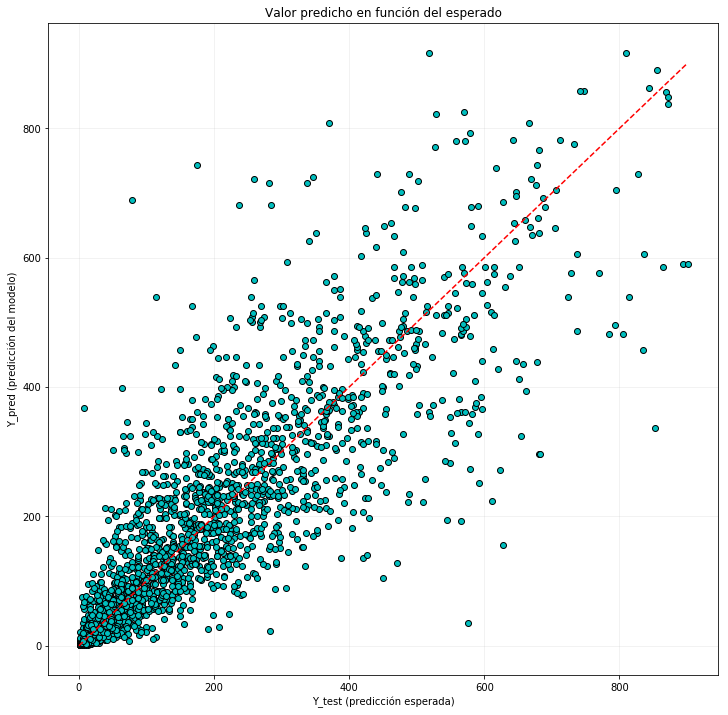

In [14]:
from sklearn.tree import DecisionTreeRegressor as Tree
import matplotlib.pyplot as plt

def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

Xdf=df.ix[:,['season','holiday','workingday','weather','temp','atemp',
        'humidity','windspeed','hour']]
Ydf=df.ix[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print ("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL VAL =%f"%kagg_val)
print ("KAGG EVAL TEST =%f"%kagg_test)
plt.figure(figsize=(12,12))
plt.grid(alpha=0.2)
plt.plot(Y_test,Y_pred_test,'o', c='c', markeredgecolor='black')
plt.plot(range(0,900), range(0,900), linestyle='--', c='r')
plt.xlabel('Y_test (predicción esperada)')
plt.ylabel('Y_pred (predicción del modelo)')
plt.title('Valor predicho en función del esperado')
plt.show()

En efecto, el puntaje obtenido por el modelo es de 0.57, lo que es mejor que el 0.59 esperado.

####  decir por que es mejoor, explicar la funciion a grandes rasgos (una linea)
A pesar de eso, a partir del gráfico se nota que las predicciones están en general, bastante alejadas de lo que se espera. Idealmente, la predicción es igual a lo esperado, por lo que se desea un comportamiento lo más parecido a la *identidad* (línea roja).

#### (c) Mejoramiento del árbol de clasificación anterior a través de la modificación de sus hiperparámetros.

La máxima profundidad se variará entre 1 y 50, mientras que se decidirá el modelo a proponer en base a su rendimiento sobre el conjunto de validación.

In [15]:
kagg_val2 = []
kagg_train2 = []
for i in range(1,51):
    model2 = Tree(random_state=0,max_depth=i)
    model2.fit(X_train,Y_train)
    Y_pred_val2 = model2.predict(X_val)
    kagg_val2.append(eval_bikemodel(Y_pred_val2,Y_val))
    
    
    Y_pred_train2 = model2.predict(X_train)
    kagg_train2.append(eval_bikemodel(Y_pred_train2,Y_train))

Y se observa el puntaje obtenido en función de la máxima profundidad.

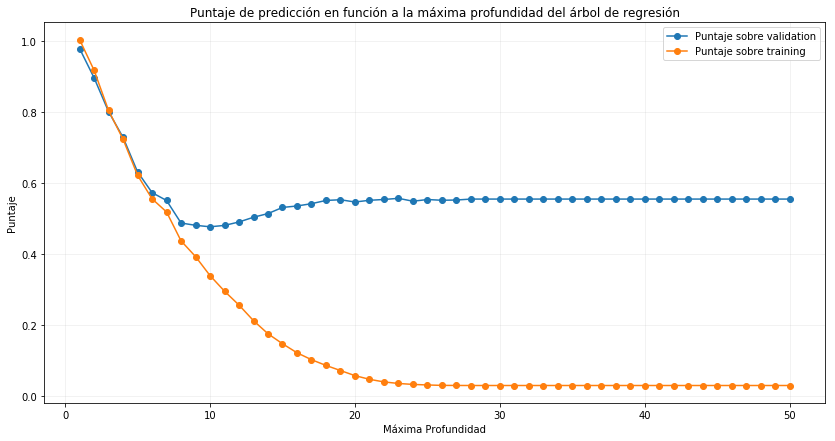

In [16]:
plt.figure(figsize=(14,7))
plt.grid(alpha=0.2)
plt.plot(range(1,51), kagg_val2, marker='o', label='Puntaje sobre validation')
plt.plot(range(1,51), kagg_train2, marker='o', label='Puntaje sobre training')
plt.legend()
plt.title('Puntaje de predicción en función a la máxima profundidad del árbol de regresión')
plt.xlabel('Máxima Profundidad')
plt.ylabel('Puntaje')
plt.show()

Se observa que el menor error de validación se encuentra cuando:

In [17]:
print('Max. Profundidad =', kagg_val2.index(min(kagg_val2))+1)

Max. Profundidad = 10


Y cuyo valor es:

In [18]:
print('Valor error validación mínimo =', round(min(kagg_val2),4))

Valor error validación mínimo = 0.4763


Comprobando el error sobre el conjunto de pruebas:

In [19]:
model2 = Tree(random_state=0,max_depth=10)
model2.fit(X_train,Y_train)
Y_pred_val2 = model2.predict(X_val)
kagg_val2 = eval_bikemodel(Y_pred_val2,Y_val)
Y_pred_test2 = model2.predict(X_test)
kagg_test2 = eval_bikemodel(Y_pred_test2,Y_test)

print('Valor error validación con max_depth=10:', round(kagg_val2,4))
print('Valor error pruebas con max_depth=10:', round(kagg_test2,4))

Valor error validación con max_depth=10: 0.4763
Valor error pruebas con max_depth=10: 0.5164


El cual representa una mejora del 0.5742-0.5164=0.0578 por sobre el árbol con parámetros por defecto. La mejora se produce porque, al limitar la profundidad del árbol, se limita el nivel de sobreajuste a los datos de entrenamiento, pues, de no poner límite, la cantidad de *splits* dividiría el espacio de los datos en muchas regiones, dentro de las cuales habrían menos datos, produciendo un aumento en la varianza, y por lo tanto, perdiendo confiabilidad y representatividad.

#### (d) Mejoramiento del rendimiento del modelo a través de modificaciones al conjunto de datos.

Se propone mejorar el árbol de regresión definido en el punto anterior haciendo modificaciones sobre la representación utilizada. Estas modificaciones consideran la extracción de las características: 

Día de la semana, 'cday' (enumerados desde 0 a 6)  
Mes (1-12 para el rango enero-diciembre)  
Año (2011 o 2012), 'year'

a partir de la fecha puesto que anteriormente solo se extrajo la hora.

A partir de esto, se espera mejorar el ranking en unas 1000 posiciones, entrando al top-1000 con un score del orden de 0.45

In [20]:
#opcional: agregar característica schedule (mañana tarde y noche)

In [21]:
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek#0:lunes,6:domingo
df['cday'] = pd.to_numeric(df['cday'])
df['month'] = pd.to_datetime(df['datetime']).dt.month#1:enero, 12: diciembre
df['month'] = pd.to_numeric(df['month'])
df['year'] = pd.to_datetime(df['datetime']).dt.year
df['year'] = pd.to_numeric(df['year'])


In [22]:
Xdf=df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']]
Ydf= df.ix[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values

names_atr = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']

Va obtenidas las nuevas características o atributos, se propone un enfoque similar al utilizado en la tarea 1, construir una función que implemente Forward Step-wise Selection (FSS). Es decir, partiendo con un modelo sin predictores (variables), agregar un predictor a la vez, re-ajustando el modelo de regresión en cada paso. 


In [23]:
def fss(xtr, ytr, xval, yval, names_x, k = 10000):
    p = xtr.shape[1]-1
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = list(np.arange(p))
    selected = [p]
    current_score = best_new_score = 0.0 # los puntajes mayores son mejores    
    mse_atribs_train = {}
    mse_atribs_test = {}
    
    while remaining and len(selected)<=k :
        score_candidates = []
        for candidate in remaining:
            #model = lm.LinearRegression(fit_intercept=True)
            model = Tree(max_depth= 10)
            indexes = selected + [candidate]
            x_train = xtr[:,indexes]
            x_val = xval[:,indexes]            
            predictions_val = model.fit(x_train, ytr).predict(x_val)
            kagg_val = eval_bikemodel(predictions_val, yval)           
            score_candidates.append((kagg_val, candidate))
        score_candidates.sort() # Ordena de menor a mayor comparando el primer elemento de cada tupla (explained_var)
        score_candidates[:] = score_candidates[::-1]
        best_new_score, best_candidate = score_candidates.pop() # saca la tupla de menor error (ultimo elemento)
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        print ("selected = %s ..."%names_x[best_candidate])
        
    return selected

A continuación, se hace uso de la función 'fss' en donde se ha propuesto extraer los primeros 9 atributos seleccionados por la función.

In [24]:
seleccionados = fss(X_train, Y_train, X_val , Y_val, names_atr)[:9]
seleccionados=np.array(names_atr)[seleccionados]

b= set(names_atr) - set(seleccionados)
print ("\nNo se considerarán los atributos:") 
b

selected = hour ...
selected = cday ...
selected = month ...
selected = holiday ...
selected = workingday ...
selected = season ...
selected = weather ...
selected = temp ...
selected = humidity ...
selected = windspeed ...
selected = atemp ...

No se considerarán los atributos:


{'atemp', 'humidity', 'windspeed'}

In [25]:
names_atr1=['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']
df2 = df.ix[:,names_atr1+['count']]


Ahora bien, se define 'caracterizar' que, a partir de la elección del conjunto de características, genera los conjuntos de entrenamiento, validación y test correspondientemente.

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

def caracterizar(df, features):
    if features == "todas":
        n_features = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']
    elif features == "originales":
        n_features = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour']
    elif features == "filtradas":
        n_features = ['season','holiday','workingday','weather','hour','cday','month','year','temp']
    elif features == "filtradas-1":
        n_features = ['season','holiday','workingday','weather','hour','cday','month','year']
    elif features == "filtradas-2":
        n_features = ['holiday','workingday','weather','hour','cday','month','year']
    elif features == "filtradas-3":
        n_features = ['workingday','weather','hour','cday','month','year']
    elif features == "filtradas-4":
        n_features = ['workingday','weather','hour','cday','month']
    elif features == "extremo":
        n_features = ['workingday','hour','cday','month']
        
    Xdf=df.ix[:,n_features]
    Ydf=df.ix[:,'count'] #target
    X_train = Xdf[0:ntrain].values
    X_val = Xdf[ntrain:nval].values
    X_test = Xdf[nval:].values
    Y_train = Ydf[0:ntrain].values
    Y_val = Ydf[ntrain:nval].values
    Y_test = Ydf[nval:].values

    return X_train,Y_train,X_val,Y_val,X_test,Y_test



Dadas las múltiples opciones de configuración para el árbol de regresión ya trabajado, se muestra a continuación el comportamiento de cada una de estas posibilidades y su correspondiente desempeño (eval_bikemodel tanto para la predicción sobre el conjunto de datos de entrenamiento como de validación).  

Otro punto importante a mencionar corresponde a que en las configuraciones presentadas, se ha definido el parámetro 'random_state=0' que equivale a una semilla inicial para todo árbol regresor a fin de hacer comparables lols resultadso de los diferentes modelos. 

In [27]:
print ("Representación de todas las caracteristicas (sin escalar)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"todas")
modelTS = Tree(random_state=0,max_depth=10)
modelTS.fit(X_train,Y_train)
Y_pred_train = modelTS.predict(X_train)
Y_pred_val = modelTS.predict(X_val)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Representación de todas las caracteristicas (escaladas)")   
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.fit_transform(X_val)

#4079 4075
modelTE = Tree(random_state=0,max_depth=10)
modelTE.fit(X_train,Y_train)
Y_pred_train = modelTE.predict(X_train)
Y_pred_val = modelTE.predict(X_val)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)      

Representación de todas las caracteristicas (sin escalar)
KAGG EVAL TRAIN =0.269763
KAGG EVAL VAL =0.406954
Representación de todas las caracteristicas (escaladas)
KAGG EVAL TRAIN =0.269763
KAGG EVAL VAL =0.407576


/etc/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [28]:
print ("Representación de las caracteristicas filtradas (sin escalar)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas")
modelFS = Tree(random_state=0,max_depth=10) 
modelFS.fit(X_train,Y_train)
Y_pred_train = modelFS.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelFS.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)


print ("Representación de las caracteristicas filtradas (escaladas)")
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.fit_transform(X_val)
modelFE = Tree(random_state=0,max_depth=10) 
modelFE.fit(X_train,Y_train)
Y_pred_train = modelFE.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelFE.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)        

Representación de las caracteristicas filtradas (sin escalar)
KAGG EVAL TRAIN =0.276828
KAGG EVAL VAL =0.404310
Representación de las caracteristicas filtradas (escaladas)
KAGG EVAL TRAIN =0.276828
KAGG EVAL VAL =0.404315


In [29]:
print ("Representación de las caracteristicas filtradas sin considerar 'temp' (sin escalar)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-1")
modelF1S = Tree(random_state=0,max_depth=10) 
modelF1S.fit(X_train,Y_train)
Y_pred_train = modelF1S.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelF1S.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Representación de las caracteristicas filtradas sin considerar 'temp' (escaladas)")
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.fit_transform(X_val)
modelF1E = Tree(random_state=0,max_depth=10) 
modelF1E.fit(X_train,Y_train)

Y_pred_train = modelF1E.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelF1E.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)   

Representación de las caracteristicas filtradas sin considerar 'temp' (sin escalar)
KAGG EVAL TRAIN =0.302409
KAGG EVAL VAL =0.393547
Representación de las caracteristicas filtradas sin considerar 'temp' (escaladas)


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


KAGG EVAL TRAIN =0.302409
KAGG EVAL VAL =0.396293


In [30]:
print ("Representación de las caracteristicas filtradas sin considerar 'temp' ni 'season' (sin escalar)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-2")
modelF2S = Tree(random_state=0,max_depth=10) 
modelF2S.fit(X_train,Y_train)
Y_pred_train = modelF2S.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelF2S.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Representación de las caracteristicas filtradas sin considerar 'temp' ni 'season' (escaladas)")
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.fit_transform(X_val)
modelF2E = Tree(random_state=0,max_depth=10) 
modelF2E.fit(X_train,Y_train)
Y_pred_train = modelF2E.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelF2E.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)   

Representación de las caracteristicas filtradas sin considerar 'temp' ni 'season' (sin escalar)
KAGG EVAL TRAIN =0.302409
KAGG EVAL VAL =0.393338
Representación de las caracteristicas filtradas sin considerar 'temp' ni 'season' (escaladas)
KAGG EVAL TRAIN =0.302409
KAGG EVAL VAL =0.396023


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [31]:
print ("Representación de las caracteristicas filtradas sin considerar 'temp' ni 'season' ni 'holiday' (sin escalar)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-3")
modelF3S = Tree(random_state=0,max_depth=10) 
modelF3S.fit(X_train,Y_train)
Y_pred_train = modelF3S.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelF3S.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Representación de las caracteristicas filtradas sin considerar 'temp' ni 'season' ni 'holiday' (escaladas)")
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.fit_transform(X_val)
modelF3E = Tree(random_state=0,max_depth=10) 
modelF3E.fit(X_train,Y_train)
Y_pred_train = modelF3E.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelF3E.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)  

Representación de las caracteristicas filtradas sin considerar 'temp' ni 'season' ni 'holiday' (sin escalar)
KAGG EVAL TRAIN =0.302049
KAGG EVAL VAL =0.392313
Representación de las caracteristicas filtradas sin considerar 'temp' ni 'season' ni 'holiday' (escaladas)
KAGG EVAL TRAIN =0.302049
KAGG EVAL VAL =0.395005


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [32]:
print ("Representación de las caracteristicas filtradas 4 (sin escalar)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-4")
modelF4S = Tree(random_state=0,max_depth=10) 
modelF4S.fit(X_train,Y_train)
Y_pred_train = modelF4S.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelF4S.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Representación de las caracteristicas filtradas 4 (escaladas)")
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.fit_transform(X_val)
modelF4E = Tree(random_state=0,max_depth=10) 
modelF4E.fit(X_train,Y_train)
Y_pred_train = modelF4E.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train) 
Y_pred_val = modelF4E.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)  

Representación de las caracteristicas filtradas 4 (sin escalar)


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


KAGG EVAL TRAIN =0.383902
KAGG EVAL VAL =0.477641
Representación de las caracteristicas filtradas 4 (escaladas)
KAGG EVAL TRAIN =0.383902
KAGG EVAL VAL =0.477492


In [33]:
print ("Representación de las caracteristicas filtradas extremo (sin escalar)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"extremo")
modelFES = Tree(random_state=0,max_depth=10) 
modelFES.fit(X_train,Y_train)
Y_pred_train = modelFES.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
Y_pred_val = modelFES.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Representación de las caracteristicas filtradas extremo (escaladas)")
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.fit_transform(X_val)
modelFEE = Tree(random_state=0,max_depth=10) 
modelFEE.fit(X_train,Y_train)
Y_pred_train = modelFEE.predict(X_train)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train) 
Y_pred_val = modelFEE.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)  

Representación de las caracteristicas filtradas extremo (sin escalar)
KAGG EVAL TRAIN =0.437555
KAGG EVAL VAL =0.515575
Representación de las caracteristicas filtradas extremo (escaladas)
KAGG EVAL TRAIN =0.437555
KAGG EVAL VAL =0.515575


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Luego de estas variaciones y considerando el desempeño de éstos sobre el conjunto de datos de validacion, es posible notar que la mejor corresponde a 'feature-3'. Es decir, aquella representación de las caracteristicas 'workingday','weather','hour','cday','month','year'  

En esta se obtuvo:  

KAGG EVAL TRAIN = 30.2049%  
KAGG EVAL VAL = 39.2313%

## hablar de esto y explicar que extremo es muy poca  informacion para una buena generalizacion 

Podrıa intentar tambien normalizando los datos o normalizando la respuesta. 

In [34]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-3")

#transforma la respuesta (Target)
Y_train = np.log(Y_train+1)
Y_val = np.log(Y_val+1)
        
modelBestT = Tree(random_state=0,max_depth=10)
modelBestT.fit(X_train,Y_train) 
Y_pred_train= modelBestT.predict(X_train)
Y_pred_val = modelBestT.predict(X_val)
Y_pred_test= modelBestT.predict(X_test)

#volver a la variable original
Y_val = np.exp(Y_val)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val = np.exp(Y_pred_val)-1
Y_pred_test = np.exp(Y_pred_test)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test= eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL VAL =%f"%kagg_val)
print ("KAGG EVAL TEST =%f"%kagg_test)


KAGG EVAL TRAIN =3.101284
KAGG EVAL VAL =0.403784
KAGG EVAL TEST =0.427427


In [35]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-3")
      
modelBestT = Tree(random_state=0,max_depth=10)
modelBestT.fit(X_train,Y_train) 
Y_pred_train= modelBestT.predict(X_train)
Y_pred_val = modelBestT.predict(X_val)
Y_pred_test= modelBestT.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test= eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL VAL =%f"%kagg_val)
print ("KAGG EVAL TEST =%f"%kagg_test)

KAGG EVAL TRAIN =0.302049
KAGG EVAL VAL =0.392313
KAGG EVAL TEST =0.414191


### decir que el no log es bueno no se por que, no lo he pensado. y poner grafico de que 'si, se ve que es mejor'

Una observaci ́on importante es que si hace una transformaci ́on a la variable respuesta (por ejemplo ra ́ız cuadrada),debe invertir esta transformaci ́on antes de evaluar el desempe ̃no con eval bikemodel (por ejemplo, elevar al cuadrado si tom ́o ra ́ız cua-drada). Con modificaciones de este tipo, podr ́ıa mejorar su ranking en unas 1000 posiciones, entrando
ya al top-1000 con un score del orden de 0.45

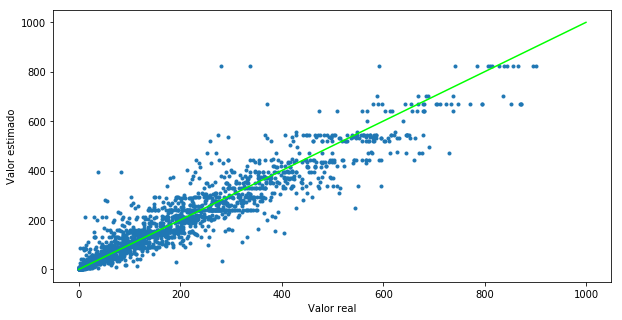

In [36]:
plt.figure(figsize=(10,5))
plt.plot(Y_test, Y_pred_test, '.')
plt.plot(range(1000),range(1000),color='lime')
plt.xlabel('Valor real')
plt.ylabel('Valor estimado')
plt.show()

#### E. Entrene una SVM no lineal para resolver el problema midiendo el efecto de las distintas representaciones descubiertas

Usando parámetros por defecto para la SVM, se debiese obtener un score del orden de 0.344, quedando definitivamente en el top-10 de la competencia.

##### Codificación de las variables categóricas  
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html

In [37]:
def categorizar(df, features):
    if features == "todas":
        n_features = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']
    elif features == "originales":
        n_features = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour']
    elif features == "filtradas":
        n_features = ['season','holiday','workingday','weather','hour','cday','month','year','temp']
    elif features == "filtradas-1":
        n_features = ['season','holiday','workingday','weather','hour','cday','month','year']
    elif features == "filtradas-2":
        n_features = ['holiday','workingday','weather','hour','cday','month','year']
    elif features == "filtradas-3":
        n_features = ['workingday','weather','hour','cday','month','year']
    elif features == "filtradas-4":
        n_features = ['workingday','weather','hour','cday','month']
    elif features == "extremo":
        n_features = ['workingday','hour','cday','month']
        
    
    todo_categ= set(['season','cday','month', 'hour', 'weather'])
    categ_efectivo=todo_categ.intersection(n_features)
        
    Xdf=df.ix[:,n_features]
    Xdf=pd.get_dummies(Xdf, columns=categ_efectivo)
    Ydf=df.ix[:,'count'] #target
    X_train = Xdf[0:ntrain].values
    X_val = Xdf[ntrain:nval].values
    X_test = Xdf[nval:].values
    Y_train = Ydf[0:ntrain].values
    Y_val = Ydf[ntrain:nval].values
    Y_test = Ydf[nval:].values
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.fit_transform(X_val)

    return X_train,Y_train,X_val,Y_val,X_test,Y_test

##### Escalar los atributos (centrados y con rangos comparables)

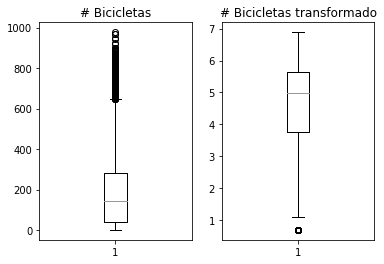

In [38]:
Y = df.ix[:,'count']
Ylog = np.log(Y+1)
f, ax = plt.subplots(1,2) 
ax[0].boxplot(Y)
ax[0].set_title('# Bicicletas')
ax[1].boxplot(Ylog)
ax[1].set_title('# Bicicletas transformado')
plt.show()

## se ve que log los centra y bla


In [39]:
from sklearn.svm import SVR
print ("Representacion de todas las caracteristicas aplicando Log() (escaladas)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"todas")
modelSS = SVR()
Y_train= np.log(Y_train+1)
modelSS.fit(X_train,Y_train)

Y_pred_train= modelSS.predict(X_train)
Y_pred_val = modelSS.predict(X_val)

Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL VAL =%f"%kagg_val)

print ("Representacion de todas las caracteristicas (escaladas)")   
modelSE = SVR()
modelSE.fit(X_train,Y_train)
Y_pred_train = modelSE.predict(X_train)
Y_pred_val = modelSE.predict(X_val)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)      
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)      

Representacion de todas las caracteristicas aplicando Log() (escaladas)
KAGG EVAL TRAIN =0.220518
KAGG EVAL VAL =0.293279
Representacion de todas las caracteristicas (escaladas)
KAGG EVAL TRAIN =1.116793
KAGG EVAL VAL =1.094467


### se observa que la evaluacion kagg empeora considerablemente cuando no se aplica la transformacion de rango (log) sobre la variable target

In [40]:
print ("Representacion de las caracteristicas originales aplicando Log() (escaladas)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"originales")
modelSOS = SVR()
Y_train= np.log(Y_train+1)
modelSOS.fit(X_train,Y_train)

Y_pred_train = modelSOS.predict(X_train)
Y_pred_val = modelSOS.predict(X_val)

Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

Representacion de las caracteristicas originales aplicando Log() (escaladas)
KAGG EVAL TRAIN =0.363297
KAGG EVAL VAL =0.415765


### decir que si es mayor que el 41.6% entonces no se considerara como opcion de filtro en las siguientes config.

In [41]:
print ("Representacion de las caracteristicas filtradas aplicando Log() (escaladas)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"filtradas")
modelSFS = SVR()
Y_train= np.log(Y_train+1)
modelSFS.fit(X_train,Y_train)

Y_pred_train = modelSFS.predict(X_train)
Y_pred_val = modelSFS.predict(X_val)

Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1

kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

Representacion de las caracteristicas filtradas aplicando Log() (escaladas)
KAGG EVAL TRAIN =0.236058
KAGG EVAL VAL =0.303102


In [42]:
print ("Representacion de las caracteristicas filtradas sin considerar 'temp' aplicando Log() (escaladas)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"filtradas-1")
modelS1S = SVR()
Y_train= np.log(Y_train+1)
modelS1S.fit(X_train,Y_train)

Y_pred_train = modelS1S.predict(X_train)
Y_pred_val = modelS1S.predict(X_val)

Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

Representacion de las caracteristicas filtradas sin considerar 'temp' aplicando Log() (escaladas)


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


KAGG EVAL TRAIN =0.251330
KAGG EVAL VAL =0.320551


In [43]:
print ("Representacion de las caracteristicas filtradas sin considerar 'temp' ni 'season' aplicando Log() (escaladas)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"filtradas-2")
modelS2S = SVR()
Y_train= np.log(Y_train+1)
modelS2S.fit(X_train,Y_train)

Y_pred_train = modelS2S.predict(X_train)
Y_pred_val = modelS2S.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

Representacion de las caracteristicas filtradas sin considerar 'temp' ni 'season' aplicando Log() (escaladas)


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


KAGG EVAL TRAIN =0.250898
KAGG EVAL VAL =0.321538


In [44]:
print ("Representacion de las caracteristicas filtradas sin considerar 'temp' ni 'season' ni 'holiday' aplicando Log() (escaladas)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"filtradas-3")
modelS3S = SVR()
Y_train= np.log(Y_train+1)
modelS3S.fit(X_train,Y_train)

Y_pred_train = modelS3S.predict(X_train)
Y_pred_val = modelS3S.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

Representacion de las caracteristicas filtradas sin considerar 'temp' ni 'season' ni 'holiday' aplicando Log() (escaladas)


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


KAGG EVAL TRAIN =0.254025
KAGG EVAL VAL =0.321922


In [45]:
print ("Representacion de las caracteristicas filtradas 4 aplicando Log() (escaladas)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"filtradas-4")
modelS4S = SVR()
Y_train= np.log(Y_train+1)
modelS4S.fit(X_train,Y_train)
Y_pred_train = modelS4S.predict(X_train)
Y_pred_val = modelS4S.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

Representacion de las caracteristicas filtradas 4 aplicando Log() (escaladas)


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


KAGG EVAL TRAIN =0.359620
KAGG EVAL VAL =0.446842


In [46]:
print ("Representacion de las caracteristicas filtradas extremo aplicando Log() (escaladas)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"extremo")
modelSES = SVR()
Y_train= np.log(Y_train+1)
modelSES.fit(X_train,Y_train)
Y_pred_train = modelSES.predict(X_train)
Y_pred_val = modelSES.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)

Representacion de las caracteristicas filtradas extremo aplicando Log() (escaladas)


/etc/Anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


KAGG EVAL TRAIN =0.427594
KAGG EVAL VAL =0.494060


### decir que justamente las ultimas dos opciones fueron mayores al 41.6% y que empeoran la soluvion


In [47]:
print ("Representacion de las caracteristicas originales aplicando Log() (escaladas)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"todas")
modelSS = SVR()
Y_train= np.log(Y_train+1)
modelSS.fit(X_train,Y_train)
Y_pred_val = modelSS.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_val=np.exp(Y_pred_val)-1

Y_pred_test = modelSS.predict(X_test)
Y_pred_test=np.exp(Y_pred_test)-1

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TEST =%f"%kagg_test)

Representacion de las caracteristicas originales aplicando Log() (escaladas)
KAGG EVAL VAL =0.293279
KAGG EVAL TEST =0.321826


In [48]:
print ("Representacion de las caracteristicas originales aplicando Log() (escaladas)")
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"filtradas")
modelSFS= SVR()
Y_train= np.log(Y_train+1)
modelSFS.fit(X_train,Y_train)
Y_pred_val = modelSFS.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_val=np.exp(Y_pred_val)-1

Y_pred_test = modelSFS.predict(X_test)
Y_pred_test=np.exp(Y_pred_test)-1

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL VAL =%f"%kagg_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TEST =%f"%kagg_test)

Representacion de las caracteristicas originales aplicando Log() (escaladas)
KAGG EVAL VAL =0.303102
KAGG EVAL TEST =0.329759


### Se observa uqe lo mejor para SVM es la configuraración de todas las caracteristicas (originales + nuevas)

#### F. Mejorar la SVM definida en E mediante la modificación de los hiper-parámetros de la máquina 

Se propone entonces variar las configuraciones de máquinas anteriores mediante el parámetro de regularización C, epsilon y kernel.

###### Kernel RBF

In [49]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"todas")
#todas, filtradas, filtradas-1
modelR1 = SVR(C=0.001,epsilon=0.001, kernel='rbf')
# C= 0.001, 0.01, 0.1, 1, 10, 100
# epsilon= 0.001, 0.01, 0.1, 1, 10, 100
#modelSES = SVR()
print ("Representacion de todas las caracteristicas aplicando Log() (escaladas)")
Y_train= np.log(Y_train+1)
modelR1.fit(X_train,Y_train)
Y_pred_train= modelR1.predict(X_train)
Y_pred_val = modelR1.predict(X_val)
Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL VAL =%f"%kagg_val)




Representacion de todas las caracteristicas aplicando Log() (escaladas)
KAGG EVAL TRAIN =1.426403
KAGG EVAL VAL =1.400162


In [50]:
# C= 0.001, 0.01, 0.1, 1, 10, 100
# epsilon= 0.001, 0.01, 0.1, 1, 10, 100
    
def iterar_kernels(kernel, C, epsilon, features):
    X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,features)
    model = SVR(C=C,epsilon=epsilon, kernel=kernel)
    print ("Representacion de aplicando Log() y escalando datos a las caracteristicas: ",features)
    Y_train= np.log(Y_train+1)
    model.fit(X_train,Y_train)
    Y_pred_train= model.predict(X_train)
    Y_pred_val = model.predict(X_val)
    Y_train=np.exp(Y_train)-1
    Y_pred_train=np.exp(Y_pred_train)-1
    Y_pred_val=np.exp(Y_pred_val)-1
    kagg_train = eval_bikemodel(Y_pred_train,Y_train)
    kagg_val = eval_bikemodel(Y_pred_val,Y_val)
    #print ("KAGG EVAL TRAIN =%f"%kagg_train)
    #print ("KAGG EVAL VAL =%f"%kagg_val)
    return kagg_train, kagg_val

In [51]:
import itertools
C= [0.01, 1, 10, 1000]
eps= [0.01, 1]
kernels= ["rbf", "poly", "linear"]
features=["todas", "filtradas"]
combine= []
combine.append(C)
combine.append(eps)
combine.append(kernels)
combine.append(features)
print(combine)


[[0.01, 1, 10, 1000], [0.01, 1], ['rbf', 'poly', 'linear'], ['todas', 'filtradas']]


In [53]:
combina2= list(itertools.product(*combine))
combina2

[(0.01, 0.01, 'rbf', 'todas'),
 (0.01, 0.01, 'rbf', 'filtradas'),
 (0.01, 0.01, 'poly', 'todas'),
 (0.01, 0.01, 'poly', 'filtradas'),
 (0.01, 0.01, 'linear', 'todas'),
 (0.01, 0.01, 'linear', 'filtradas'),
 (0.01, 1, 'rbf', 'todas'),
 (0.01, 1, 'rbf', 'filtradas'),
 (0.01, 1, 'poly', 'todas'),
 (0.01, 1, 'poly', 'filtradas'),
 (0.01, 1, 'linear', 'todas'),
 (0.01, 1, 'linear', 'filtradas'),
 (1, 0.01, 'rbf', 'todas'),
 (1, 0.01, 'rbf', 'filtradas'),
 (1, 0.01, 'poly', 'todas'),
 (1, 0.01, 'poly', 'filtradas'),
 (1, 0.01, 'linear', 'todas'),
 (1, 0.01, 'linear', 'filtradas'),
 (1, 1, 'rbf', 'todas'),
 (1, 1, 'rbf', 'filtradas'),
 (1, 1, 'poly', 'todas'),
 (1, 1, 'poly', 'filtradas'),
 (1, 1, 'linear', 'todas'),
 (1, 1, 'linear', 'filtradas'),
 (10, 0.01, 'rbf', 'todas'),
 (10, 0.01, 'rbf', 'filtradas'),
 (10, 0.01, 'poly', 'todas'),
 (10, 0.01, 'poly', 'filtradas'),
 (10, 0.01, 'linear', 'todas'),
 (10, 0.01, 'linear', 'filtradas'),
 (10, 1, 'rbf', 'todas'),
 (10, 1, 'rbf', 'filtradas')

# NO EJECUTAR LA SIGUIENTE CELDA

In [ ]:
for item in combina2:
    C=item[0]
    epsilon=item[1]
    kernel=item[2]
    feat=item[3]
    t,v= iterar_kernels(kernel, C, epsilon, feat)
    print ("KAGG EVAL TRAIN BAJO KERNEL ",kernel,", C= ", C, " Y EPS= ", epsilon, "EQUIVALE A ", t)
    print ("KAGG EVAL VAL BAJO KERNEL ",kernel,", C= ", C, " Y EPS= ", epsilon, "EQUIVALE A ", v)

Representacion de aplicando Log() y escalando datos a las caracteristicas:  todas
KAGG EVAL TRAIN BAJO KERNEL  rbf , C=  0.01  Y EPS=  0.01 EQUIVALE A  1.09057985634
KAGG EVAL VAL BAJO KERNEL  rbf , C=  0.01  Y EPS=  0.01 EQUIVALE A  1.0698686588
Representacion de aplicando Log() y escalando datos a las caracteristicas:  filtradas
KAGG EVAL TRAIN BAJO KERNEL  rbf , C=  0.01  Y EPS=  0.01 EQUIVALE A  1.10659721832
KAGG EVAL VAL BAJO KERNEL  rbf , C=  0.01  Y EPS=  0.01 EQUIVALE A  1.08468199031
Representacion de aplicando Log() y escalando datos a las caracteristicas:  todas
KAGG EVAL TRAIN BAJO KERNEL  poly , C=  0.01  Y EPS=  0.01 EQUIVALE A  1.279673964
KAGG EVAL VAL BAJO KERNEL  poly , C=  0.01  Y EPS=  0.01 EQUIVALE A  1.25299951279
Representacion de aplicando Log() y escalando datos a las caracteristicas:  filtradas
KAGG EVAL TRAIN BAJO KERNEL  poly , C=  0.01  Y EPS=  0.01 EQUIVALE A  1.28153002034
KAGG EVAL VAL BAJO KERNEL  poly , C=  0.01  Y EPS=  0.01 EQUIVALE A  1.25429268593

KAGG EVAL TRAIN BAJO KERNEL  poly , C=  10  Y EPS=  1 EQUIVALE A  0.665546301948
KAGG EVAL VAL BAJO KERNEL  poly , C=  10  Y EPS=  1 EQUIVALE A  0.743066320607
Representacion de aplicando Log() y escalando datos a las caracteristicas:  todas
KAGG EVAL TRAIN BAJO KERNEL  linear , C=  10  Y EPS=  1 EQUIVALE A  0.629065086043
KAGG EVAL VAL BAJO KERNEL  linear , C=  10  Y EPS=  1 EQUIVALE A  0.654675070139
Representacion de aplicando Log() y escalando datos a las caracteristicas:  filtradas
KAGG EVAL TRAIN BAJO KERNEL  linear , C=  10  Y EPS=  1 EQUIVALE A  0.629324508797
KAGG EVAL VAL BAJO KERNEL  linear , C=  10  Y EPS=  1 EQUIVALE A  0.654955157923
Representacion de aplicando Log() y escalando datos a las caracteristicas:  todas
KAGG EVAL TRAIN BAJO KERNEL  rbf , C=  1000  Y EPS=  0.01 EQUIVALE A  0.0198863601744
KAGG EVAL VAL BAJO KERNEL  rbf , C=  1000  Y EPS=  0.01 EQUIVALE A  0.423182715989
Representacion de aplicando Log() y escalando datos a las caracteristicas:  filtradas
KAGG EV

La configuración que acusa el menor error de validación equivale a: 

###### Kernel: RBF,   Epsilon: 0.01,   C: 1,   features: todas 
###### Error de entrenamiento: 21.8523882487 % 
###### Error de validación: 29.2759342642 % 

Por ello se propone aplicar dichos parámetros a la máquina de soporte vectorial con el fin de obtener el error sobre el conjunto de testing.  
Se observa que efectivamente se logra una mejora en términos del error de validación (0.05% app) respecto al logro previo (29.3279%).  
Si bien este valor no representa un aumento considerable, es notable la robustez de una SVM cuando se varian los parámetros de ésta.

In [56]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"todas")
model = SVR(C=1,epsilon=0.01, kernel='rbf')
Y_train= np.log(Y_train+1)
model.fit(X_train,Y_train)
Y_pred_train= model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
Y_train=np.exp(Y_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_val=np.exp(Y_pred_val)-1
Y_pred_test=np.exp(Y_pred_test)-1
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL VAL =%f"%kagg_val)
print ("KAGG EVAL TEST =%f"%kagg_test)
#return kagg_train, kagg_val

KAGG EVAL TRAIN =0.218524
KAGG EVAL VAL =0.292759
KAGG EVAL TEST =0.323682


Ahora bien, en términos del error sobre el conjunto de testeo, no se evidencia ninguna mejora. Es más, el error aumenta en un 0.18%.   

#### G. Utilización del dataset de validación para el entrenamiento, cross validation 

A continuación se evalúa el efecto de utilizar el dataset de validación para entrenamiento tanto para la selección de los parámetros del árbol regresor como para la SVM haciendo uso de validación cruzada.  

La validación cruzada es una técnica utilizada para evaluar los resultados de un análisis estadístico y probar la independencia de la partición hecha para datos de entrenamiento y validación. Dado un número de iteraciones, en cada una de ellas se modela una nueva máquina tal que se obtenga el menor error de predicción en base a los datos de entrenamiento de la división ('fold'). Este valor variará dependiendo de las características de los datos utilizados en cada ciclo e indicará la precisión del modelo utilizado.  


In [84]:
from sklearn.model_selection import KFold

X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-3")
XTnew_train= np.vstack((X_train, X_val))
YTnew_train= np.hstack((Y_train, Y_val))
best=2
i_esimo_best=0
for i in range(1,30):
    #cross validation Tree
    kf = KFold(n_splits=10)
    kagg_cv = 0
    for train, val in kf.split(XTnew_train):
        #model = SVR(C=1,epsilon=0.01, kernel='rbf')
        model = Tree(random_state=0,max_depth=i)
        model.fit(XTnew_train[train], YTnew_train[train])
        yhat_val = model.predict(XTnew_train[val])
        ytrue_val = YTnew_train[val]
        score_fold = eval_bikemodel(yhat_val,ytrue_val)
        kagg_cv += score_fold
    kagg_cv = kagg_cv / 10
    if kagg_cv<best:
        print ("Nuevo mejor desempeño: ", kagg_cv, "en el árbol de max_depth= ", i)
        best= kagg_cv
        i_esimo_best=i

print ("El i-esimo arbol de mejor desempeño es: ", i_esimo_best)
    

Nuevo mejor desempeño:  0.984888715519 en el árbol de max_depth=  1
Nuevo mejor desempeño:  0.919136255089 en el árbol de max_depth=  2
Nuevo mejor desempeño:  0.825943287098 en el árbol de max_depth=  3
Nuevo mejor desempeño:  0.753970235602 en el árbol de max_depth=  4
Nuevo mejor desempeño:  0.632582694584 en el árbol de max_depth=  5
Nuevo mejor desempeño:  0.579941110576 en el árbol de max_depth=  6
Nuevo mejor desempeño:  0.536497308069 en el árbol de max_depth=  7
Nuevo mejor desempeño:  0.463840777509 en el árbol de max_depth=  8
Nuevo mejor desempeño:  0.431120440147 en el árbol de max_depth=  9
Nuevo mejor desempeño:  0.417723058197 en el árbol de max_depth=  10
Nuevo mejor desempeño:  0.41378585351 en el árbol de max_depth=  11
El i-esimo arbol de mejor desempeño es:  11


In [81]:
modelCV_T = Tree(random_state=0,max_depth=11)
modelCV_T.fit(XTnew_train,YTnew_train) 
Y_pred_train= modelCV_T.predict(XTnew_train)
Y_pred_test= modelCV_T.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,YTnew_train)
kagg_test= eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL TEST =%f"%kagg_test)

KAGG EVAL TRAIN =0.265691
KAGG EVAL TEST =0.391066


In [91]:
#cross validation SVR
from sklearn.model_selection import KFold
#Kernel: RBF, Epsilon: 0.01, C: 1, features: todas
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"todas")
XTnew_train= np.vstack((X_train, X_val))
YTnew_train= np.hstack((Y_train, Y_val))

YTnew_train= np.log(YTnew_train+1)

Cs=[0.01, 0.1, 1]
Eps=[0.01, 0.1, 1]
best=2
c_best=0
eps_best= 0
for i in Cs: #C
    for j in Eps: #epsilon
        #cross validation SVR
        kf = KFold(n_splits=10)
        kagg_cv = 0
        for train, val in kf.split(XTnew_train):
            model = SVR(C=i,epsilon=j, kernel='rbf')
            model.fit(XTnew_train[train], YTnew_train[train])
            yhat_val = model.predict(XTnew_train[val])
            ytrue_val = np.exp(YTnew_train[val])-1
            yhat_val= np.exp(yhat_val)-1
            score_fold = eval_bikemodel(yhat_val,ytrue_val)
            kagg_cv += score_fold
        kagg_cv = kagg_cv / 10
        if kagg_cv<best:
            print ("Nuevo mejor desempeño:", kagg_cv, "en SVM de C=", i, "y epsilon=", j)
            best= kagg_cv
            c_best=i
            eps_best=j

Nuevo mejor desempeño: 1.06414382658 en SVM de C= 0.01 y epsilon= 0.01
Nuevo mejor desempeño: 1.06228318533 en SVM de C= 0.01 y epsilon= 0.1
Nuevo mejor desempeño: 0.449465939453 en SVM de C= 0.1 y epsilon= 0.01
Nuevo mejor desempeño: 0.313898639321 en SVM de C= 1 y epsilon= 0.01
Nuevo mejor desempeño: 0.311738526088 en SVM de C= 1 y epsilon= 0.1


In [98]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = categorizar(df2,"todas")
XTnew_train= np.vstack((X_train, X_val))
YTnew_train= np.hstack((Y_train, Y_val))
YTnew_train= np.log(YTnew_train+1)
model = SVR(C=1,epsilon=0.1, kernel='rbf')
model.fit(XTnew_train,YTnew_train)
Y_pred_train= model.predict(XTnew_train)
Y_pred_test= model.predict(X_test)
YTnew_train=np.exp(YTnew_train)-1
Y_pred_train=np.exp(Y_pred_train)-1
Y_pred_test=np.exp(Y_pred_test)-1
kagg_train = eval_bikemodel(Y_pred_train,YTnew_train)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL TEST =%f"%kagg_test)

KAGG EVAL TRAIN =0.220670
KAGG EVAL TEST =0.315039


### comentar lo que se observa

#### H. Evaluar el efecto de utilizar un ensamblado de 2 m´aquinas de aprendizaje para predecir la demanda total de bicicletas. Un modelo se especializar´a en la predicci´on de la demanda de bicicletas de parte de usuarios registrados y otra en la predicci´on de la demanda de usuarios casuales. Hay razones claras para pensar que los patrones son distintos.

In [ ]:
Ydf=df.ix[:,'count'] #demanda total
Ydf=df.ix[:,'registered'] #demanda registrada
Ydf=df.ix[:,'casual'] #demanda casual

#### I. Evaluar el efecto de utilizar un algoritmo genérico para ensamblar máquinas de aprendizaje para predecir la demanda total de bicicletas. 

# discuta la evoluci´on a medida que aumenta el n´umero de m´aquinas

In [93]:
from sklearn.ensemble import RandomForestRegressor as RFR

X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-3") 
modelRFR = RFR(n_estimators=10,max_depth=11,random_state=0)
modelRFR.fit(X_train, Y_train)
y_pred_train=modelRFR.predict(X_train)
y_pred_val=modelRFR.predict(X_val)
kagg_train = eval_bikemodel(y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(y_pred_val,Y_val)
print ("KAGG EVAL TRAIN =%f"%kagg_val)

KAGG EVAL TRAIN =0.265022
KAGG EVAL TRAIN =0.347335


In [95]:
modelRFR = RFR(n_estimators=15,max_depth=11,random_state=0)
modelRFR.fit(X_train, Y_train)
y_pred_train=modelRFR.predict(X_train)
y_pred_val=modelRFR.predict(X_val)
kagg_train = eval_bikemodel(y_pred_train,Y_train)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
kagg_val = eval_bikemodel(y_pred_val,Y_val)
print ("KAGG EVAL TRAIN =%f"%kagg_val)

KAGG EVAL TRAIN =0.262145
KAGG EVAL TRAIN =0.347942


In [103]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = caracterizar(df2,"filtradas-3") 
trains=[]
vals=[]
for i in range(5,35):
    print ("n_estimator:", i)
    modelRFR = RFR(n_estimators=i,max_depth=11,random_state=0)
    modelRFR.fit(X_train, Y_train)
    y_pred_train=modelRFR.predict(X_train)
    y_pred_val=modelRFR.predict(X_val)
    kagg_train = eval_bikemodel(y_pred_train,Y_train)
    trains.append(kagg_train)
    kagg_val = eval_bikemodel(y_pred_val,Y_val)
    print ("KAGG EVAL TRAIN:", kagg_train, "KAGG EVAL TRAIN:", kagg_val,"\n")
    vals.append(kagg_val)

n_estimator: 5
KAGG EVAL TRAIN: 0.273947341038 KAGG EVAL TRAIN: 0.355257986226 

n_estimator: 6
KAGG EVAL TRAIN: 0.26982241968 KAGG EVAL TRAIN: 0.353438526352 

n_estimator: 7
KAGG EVAL TRAIN: 0.266857896722 KAGG EVAL TRAIN: 0.350455228122 

n_estimator: 8
KAGG EVAL TRAIN: 0.265723335399 KAGG EVAL TRAIN: 0.349447861087 

n_estimator: 9
KAGG EVAL TRAIN: 0.265826461256 KAGG EVAL TRAIN: 0.349504235596 

n_estimator: 10
KAGG EVAL TRAIN: 0.265021585849 KAGG EVAL TRAIN: 0.347335373873 

n_estimator: 11
KAGG EVAL TRAIN: 0.266213452971 KAGG EVAL TRAIN: 0.349974379388 

n_estimator: 12
KAGG EVAL TRAIN: 0.264369193018 KAGG EVAL TRAIN: 0.348921915866 

n_estimator: 13
KAGG EVAL TRAIN: 0.263238156976 KAGG EVAL TRAIN: 0.348242999202 

n_estimator: 14
KAGG EVAL TRAIN: 0.262518313786 KAGG EVAL TRAIN: 0.347266841139 

n_estimator: 15
KAGG EVAL TRAIN: 0.262144753262 KAGG EVAL TRAIN: 0.347942175033 

n_estimator: 16
KAGG EVAL TRAIN: 0.261760372403 KAGG EVAL TRAIN: 0.346521563541 

n_estimator: 17
KAGG E